# Tutorial: `spec_mod`

## Sample data
Sample imagery captured from a [Resonon](https://resonon.com/) Pika II VIS-NIR line scanning imager and ancillary sample files can be downloaded from this [link](https://drive.google.com/drive/folders/1KpOBB4-qghedVFd8ukQngXNwUit8PFy_?usp=sharing).

Before trying this tutorial on your own machine, please download the [sample files](https://drive.google.com/drive/folders/1KpOBB4-qghedVFd8ukQngXNwUit8PFy_?usp=sharing) and place into a local directory of your choosing (and do not change the file names). Indicate the location of your sample files by modifying `data_dir`:

In [1]:
data_dir = r'F:\\nigo0024\Documents\hs_process_demo'

***

## Confirm your environment

Before trying the tutorials, be sure `hs_process` and its dependencies are [properly installed](installation.html#). If you installed in a *virtual environment*, first check we are indeed using the Python instance that was installed with the virtual environment:

In [2]:
import sys
import hs_process
print('Python install location: {0}'.format(sys.executable))
print('Version: {0}'.format(hs_process.__version__))

Python install location: C:\Users\nigo0024\Anaconda3\envs\msi_sip\python.exe
Version: 0.0.4


The *spec* folder that contains `python.exe` tells me that the activated Python instance is indeed in the `spec` environment, just as I intend. If you created a virtual environment, but your `python.exe` is not in the `envs\spec` directory, you either did not properly create your virtual environment or you are not pointing to the correct Python installation in your IDE (e.g., Spyder, Jupyter notebook, etc.).  

***

## `spec_mod.load_spyfile`
Loads a `SpyFile` (Spectral Python object) for data access and/or manipulation by the `hstools` class. [[API]](api/hs_process.spec_mod.html#hs_process.spec_mod.load_spyfile)

Load and initialize the `hsio` and `spec_mod` modules

In [3]:
import os
from hs_process import hsio
from hs_process import spec_mod

fname_in = os.path.join(data_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7-Radiance Conversion-Georectify Airborne Datacube-Convert Radiance Cube to Reflectance from Measured Reference Spectrum.bip.hdr')
io = hsio(fname_in)
my_spec_mod = spec_mod(io.spyfile)

Load datacube using ``spec_mod.load_spyfile``

In [4]:
my_spec_mod.load_spyfile(io.spyfile)
my_spec_mod.spyfile

	Data Source:   'F:\\nigo0024\Documents\hs_process_demo\Wells_rep2_20180628_16h56m_pika_gige_7-Radiance Conversion-Georectify Airborne Datacube-Convert Radiance Cube to Reflectance from Measured Reference Spectrum.bip'
	# Rows:            617
	# Samples:        1300
	# Bands:           240
	Interleave:        BIP
	Quantization:  32 bits
	Data format:   float32

***

## `spec_mod.spec_derivative`
Calculates the numeric derivative spectra from spyfile_spec. [[API]](api/hs_process.hstools.html#hs_process.spec_mod.spec_derivative)

Load and initialize `hsio`

In [5]:
import os
from hs_process import hsio
from hs_process import spec_mod
fname_hdr_spec = os.path.join(data_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_611-cube-to-spec-mean.spec.hdr')
io = hsio()
io.read_spec(fname_hdr_spec)
my_spec_mod = spec_mod(io.spyfile_spec)

Calculate the numeric derivative.

In [6]:
spec_dydx, metadata_dydx = my_spec_mod.spec_derivative(io.spyfile_spec)  # Be sure this is the spec spyfile and not a full array

Plot the numeric derivative spectra and compare against the original spectra.

Text(0.5, 1.0, 'API Example: `spec_mod.spec_derivative`')

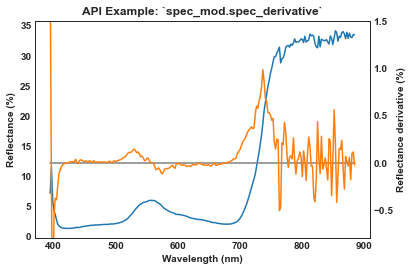

In [7]:
import numpy as np
import seaborn as sns
sns.set_style("ticks")
wl_x = np.array([float(i) for i in metadata_dydx['wavelength']])
y_ref = io.spyfile_spec.open_memmap()[0,0,:]*100
ax1 = sns.lineplot(wl_x, y_ref)
ax2 = ax1.twinx()
ax2 = sns.lineplot(wl_x, 0, ax=ax2, color='gray')
ax2 = sns.lineplot(wl_x, spec_dydx[0,0,:]*100, ax=ax2, color=sns.color_palette()[1])
ax2.set(ylim=(-0.8, 1.5))
ax1.set_xlabel('Wavelength (nm)', weight='bold')
ax1.set_ylabel('Reflectance (%)', weight='bold')
ax2.set_ylabel('Reflectance derivative (%)', weight='bold')
ax1.set_title(r'API Example: `spec_mod.spec_derivative`', weight='bold')

Save the derivative spectra to file.

In [8]:
fname_spec_der = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7_plot_611-spec-derivative.spec.hdr')
io.write_spec(fname_spec_der, spec_dydx, df_std=None, metadata=metadata_dydx, force=True)

***

## `spec_mod.spectral_clip`
Removes/clips designated wavelength bands from the hyperspectral datacube. [[API]](api/hs_process.spec_mod.html#hs_process.spec_mod.spectral_clip)

Load and initialize the `hsio` and `spec_mod` modules

In [9]:
import os
from hs_process import hsio
from hs_process import spec_mod

fname_hdr = os.path.join(data_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7-Radiance Conversion-Georectify Airborne Datacube-Convert Radiance Cube to Reflectance from Measured Reference Spectrum.bip.hdr')
io = hsio()
io.read_cube(fname_hdr)
my_spec_mod = spec_mod(io.spyfile)

Using `spec_mod.spectral_clip`, clip all spectral bands below *420 nm* and above *880 nm*, as well as the bands near the oxygen absorption (i.e., *760-776 nm*) and water absorption (i.e., *813-827 nm*) regions.

In [10]:
array_clip, metadata_clip = my_spec_mod.spectral_clip(wl_bands=[[0, 420], [760, 776], [813, 827], [880, 1000]])

Plot the spectra of the unclippe hyperspectral image and compare to that of the clipped image for a single pixel.

Text(0.5, 1.0, 'API Example: `spec_mod.spectral_clip`')

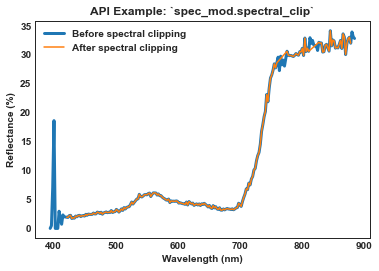

In [11]:
import seaborn as sns
from ast import literal_eval

spy_hs = my_spec_mod.spyfile.open_memmap()  # datacube before smoothing
meta_bands = list(io.tools.meta_bands.values())
meta_bands_clip = sorted([float(i) for i in literal_eval(metadata_clip['wavelength'])])

ax = sns.lineplot(x=meta_bands, y=spy_hs[200][800]*100, label='Before spectral clipping', linewidth=3)
ax = sns.lineplot(x=meta_bands_clip, y=array_clip[200][800]*100, label='After spectral clipping', ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `spec_mod.spectral_clip`', weight='bold')

Save the clipped datacube

In [12]:
from pathlib import Path

Path(os.path.join(data_dir, 'spec_mod')).mkdir(parents=True, exist_ok=True)
fname_hdr_clip = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7-clip.bip.hdr')
io.write_cube(fname_hdr_clip, array_clip, metadata_clip, force=True)

***

## `spec_mod.spectral_mimic`
Mimics the response of a multispectral sensor based on transmissivity of sensor bands across a range of wavelength values by calculating its weighted average response and interpolating the hyperspectral response. [[API]](api/hs_process.spec_mod.html#hs_process.spec_mod.spectral_mimic)

Load and initialize the `hsio` and `spec_mod` modules

In [13]:
import os
from hs_process import hsio
from hs_process import spec_mod

fname_hdr = os.path.join(data_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7-Radiance Conversion-Georectify Airborne Datacube-Convert Radiance Cube to Reflectance from Measured Reference Spectrum.bip.hdr')
io = hsio()
io.read_cube(fname_hdr)

my_spec_mod = spec_mod(io.spyfile)

Use `spec_mod.spectral_mimic` to mimic the [Sentinel-2A spectral response function](https://sentinel.esa.int/web/sentinel/document-library/content/-/article/sentinel-2a-spectral-responses).

In [14]:
array_s2a, metadata_s2a = my_spec_mod.spectral_mimic(sensor='sentinel-2a', center_wl='weighted')

Plot the spectra of the hyperspectral image and compare to that of the mimicked Sentinel-2A for a single pixel.

Text(0.5, 1.0, 'API Example: `spec_mod.spectral_mimic`')

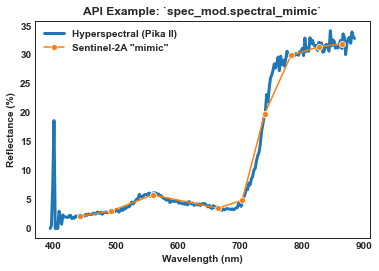

In [15]:
import seaborn as sns

spy_hs = my_spec_mod.spyfile.open_memmap()  # datacube before smoothing
meta_bands = list(io.tools.meta_bands.values())
meta_bands_s2a = sorted([float(i) for i in literal_eval(metadata_s2a['wavelength'])])

ax = sns.lineplot(x=meta_bands, y=spy_hs[200][800]*100, label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_s2a, y=array_s2a[200][800]*100, label='Sentinel-2A "mimic"', marker='o', ms=6, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `spec_mod.spectral_mimic`', weight='bold')

Use `spec_mod.spectral_mimic` to mimic the [Sentera 6x spectral configuration](https://sentera.com/6x/) and compare to both hyperspectral and Sentinel-2A.

Text(0.5, 1.0, 'API Example: `spec_mod.spectral_mimic`')

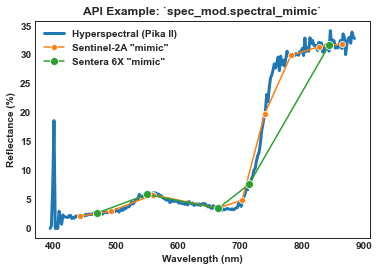

In [16]:
array_6x, metadata_6x = my_spec_mod.spectral_mimic(sensor='sentera_6x', center_wl='peak')
meta_bands_6x = sorted([float(i) for i in literal_eval(metadata_6x['wavelength'])])

ax = sns.lineplot(x=meta_bands, y=spy_hs[200][800]*100, label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_s2a, y=array_s2a[200][800]*100, label='Sentinel-2A "mimic"', marker='o', ms=6, ax=ax)
ax = sns.lineplot(x=meta_bands_6x, y=array_6x[200][800]*100, label='Sentera 6X "mimic"', marker='o', ms=8, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `spec_mod.spectral_mimic`', weight='bold')

And finally, mimic the [Micasense RedEdge-MX](https://micasense.com/rededge-mx/) and compare to hyperspectral, Sentinel-2A, and Sentera 6X.

Text(0.5, 1.0, 'API Example: `spec_mod.spectral_mimic`')

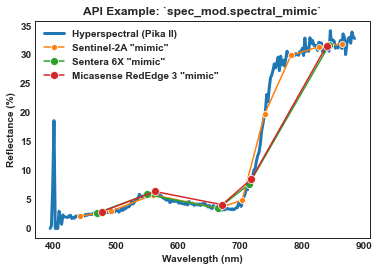

In [17]:
array_re3, metadata_re3 = my_spec_mod.spectral_mimic(sensor='micasense_rededge_3', center_wl='peak')
meta_bands_re3 = sorted([float(i) for i in literal_eval(metadata_re3['wavelength'])])

ax = sns.lineplot(x=meta_bands, y=spy_hs[200][800]*100, label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_s2a, y=array_s2a[200][800]*100, label='Sentinel-2A "mimic"', marker='o', ms=6, ax=ax)
ax = sns.lineplot(x=meta_bands_6x, y=array_6x[200][800]*100, label='Sentera 6X "mimic"', marker='o', ms=8, ax=ax)
ax = sns.lineplot(x=meta_bands_re3, y=array_re3[200][800]*100, label='Micasense RedEdge 3 "mimic"', marker='o', ms=8, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `spec_mod.spectral_mimic`', weight='bold')

Save the mimicked datacubes using `hsio.write_cube`

In [18]:
fname_hdr_mimic_s2a = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7-mimic-s2a.bip.hdr')
fname_hdr_mimic_6x = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7-mimic-6x.bip.hdr')
fname_hdr_mimic_re3 = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7-mimic-re3.bip.hdr')
io.write_cube(fname_hdr_mimic_s2a, array_s2a, metadata_s2a, force=True)
io.write_cube(fname_hdr_mimic_6x, array_6x, metadata_6x, force=True)
io.write_cube(fname_hdr_mimic_re3, array_re3, metadata_re3, force=True)

***

## `spec_mod.spectral_resample`
Performs pixel-wise resampling of spectral bands via binning (calculates the mean across all bands within each `bandwidth` region for each image pixel). [[API]](api/hs_process.spec_mod.html#hs_process.spec_mod.spectral_resample)

Load and initialize the `hsio` and `spec_mod` modules

In [19]:
import os
from hs_process import hsio
from hs_process import spec_mod

fname_hdr = os.path.join(data_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7-Radiance Conversion-Georectify Airborne Datacube-Convert Radiance Cube to Reflectance from Measured Reference Spectrum.bip.hdr')
io = hsio()
io.read_cube(fname_hdr)

my_spec_mod = spec_mod(io.spyfile)

Use `spec_mod.spectral_resample` to "bin" the datacube to bands with *20 nm* bandwidths.

In [20]:
array_bin, metadata_bin = my_spec_mod.spectral_resample(bandwidth=20)

Plot the spectra for both the hyperspectral image and that of the binned image bands (for a single "vegetation" pixel).

Text(0.5, 1.0, 'API Example: `spec_mod.spectral_resample`')

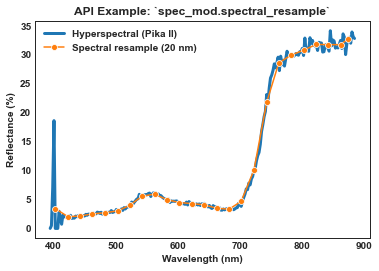

In [21]:
import seaborn as sns
from ast import literal_eval

spy_hs = my_spec_mod.spyfile.open_memmap()  # datacube before smoothing
meta_bands = list(io.tools.meta_bands.values())
# meta_bands_bin = sorted([float(i) for i in metadata_bin['wavelength']])
meta_bands_bin = sorted([float(i) for i in literal_eval(metadata_bin['wavelength'])])

ax = sns.lineplot(x=meta_bands, y=spy_hs[200][800]*100, label='Hyperspectral (Pika II)', linewidth=3)
ax = sns.lineplot(x=meta_bands_bin, y=array_bin[200][800]*100, label='Spectral resample (20 nm)', marker='o', ms=6, ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `spec_mod.spectral_resample`', weight='bold')

Save the spectrally resampled datacube using `hsio.write_cube`

In [22]:
fname_hdr_bin = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7-bin-20.bip.hdr')
io.write_cube(fname_hdr_bin, array_bin, metadata_bin, force=True)

***

## `spec_mod.spectral_smooth`
Performs Savitzky-Golay smoothing on the spectral domain. [[API]](api/hs_process.spec_mod.html#hs_process.spec_mod.spectral_smooth)

Load and initialize the `hsio` and `spec_mod` modules

In [23]:
import os
from hs_process import hsio
from hs_process import spec_mod

fname_hdr = os.path.join(data_dir, 'Wells_rep2_20180628_16h56m_pika_gige_7-Radiance Conversion-Georectify Airborne Datacube-Convert Radiance Cube to Reflectance from Measured Reference Spectrum.bip.hdr')
io = hsio()
io.read_cube(fname_hdr)
my_spec_mod = spec_mod(io.spyfile)

Use `spec_mod.spectral_smooth` to perform a *Savitzky-Golay* smoothing operation across the hyperspectral spectral signature.

In [24]:
array_smooth, metadata_smooth = my_spec_mod.spectral_smooth(window_size=11, order=2)

Plot the spectra of an *individual pixel* to visualize the result of the smoothing procedure. 

Text(0.5, 1.0, 'API Example: `spec_mod.spectral_smooth`')

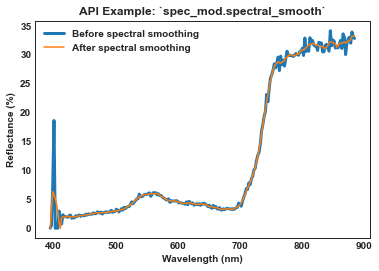

In [25]:
import seaborn as sns
from ast import literal_eval

spy_hs = my_spec_mod.spyfile.open_memmap()  # datacube before smoothing
meta_bands = list(io.tools.meta_bands.values())
meta_bands_smooth = sorted([float(i) for i in metadata_smooth['wavelength']])

ax = sns.lineplot(x=meta_bands, y=spy_hs[200][800]*100, label='Before spectral smoothing', linewidth=3)
ax = sns.lineplot(x=meta_bands_smooth, y=array_smooth[200][800]*100, label='After spectral smoothing', ax=ax)
ax.set_xlabel('Wavelength (nm)', weight='bold')
ax.set_ylabel('Reflectance (%)', weight='bold')
ax.set_title(r'API Example: `spec_mod.spectral_smooth`', weight='bold')

Save the smoothed datacube using `hsio.write_cube`

In [26]:
fname_hdr_smooth = os.path.join(data_dir, 'spec_mod', 'Wells_rep2_20180628_16h56m_pika_gige_7-smooth.bip.hdr')
io.write_cube(fname_hdr_smooth, array_smooth, metadata_smooth, force=True)